In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

https://rdrr.io/cran/fpp/man/a10.html

In [2]:
df = pd.read_csv('../data/AusAntidiabeticDrug.csv')
df.head(10)

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
5,1991-12-01,4.306371
6,1992-01-01,5.088335
7,1992-02-01,2.814520
8,1992-03-01,2.985811
9,1992-04-01,3.204780


In [3]:
df.tail(10)

,ds,y
194,2007-09-01,22.930357
195,2007-10-01,23.263340
196,2007-11-01,25.250030
197,2007-12-01,25.806090
198,2008-01-01,29.665356
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510
203,2008-06-01,19.431740


In [4]:
df.shape

(204, 2)

## Visualization 

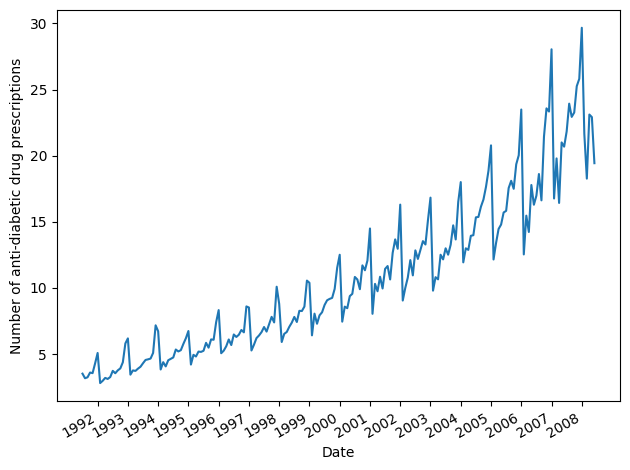

In [5]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH11_F01_peixeiro.png', dpi=300)

## Exploration 

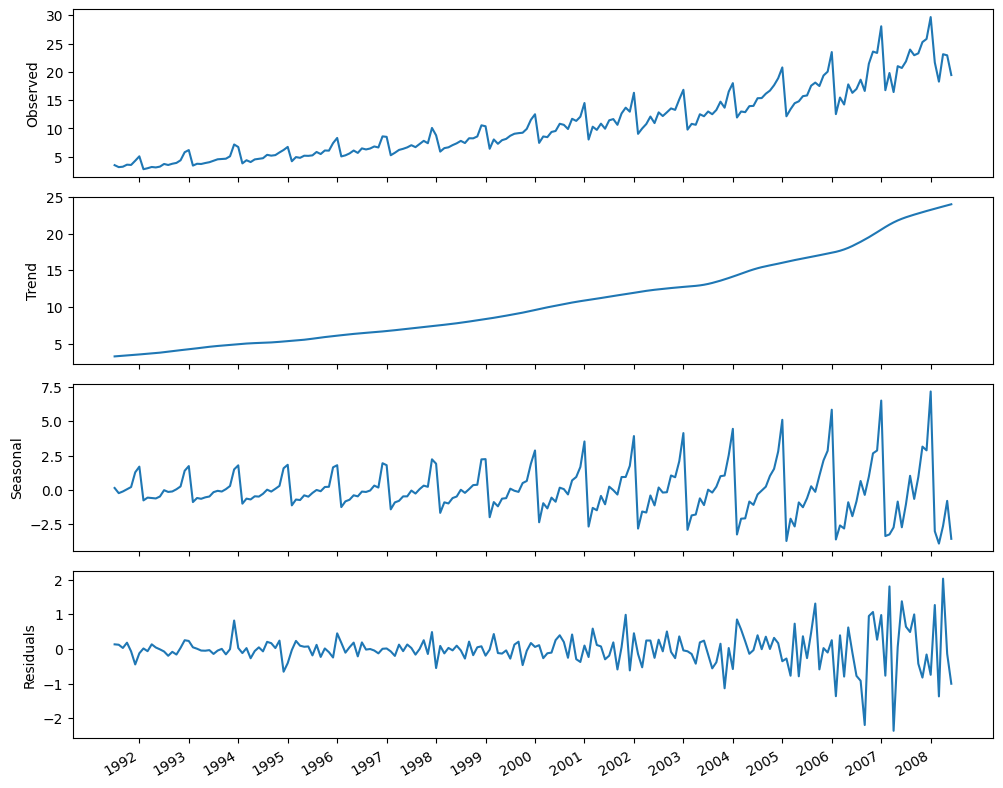

In [6]:
decomposition = STL(df.y, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH11_F02_peixeiro.png', dpi=300)

In [7]:
ad_fuller_result = adfuller(decomposition.seasonal)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -10.374408613674929
p-value: 2.2208429039488454e-18


## Modeling 

In [8]:
ad_fuller_result = adfuller(df.y)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 3.1451856893067442
p-value: 1.0


In [9]:
#y_diff = np.diff(df.y, n=1)
y_seasonal_diff = df['y'].diff(periods=12)[12:]

ad_fuller_result = adfuller(y_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
y_seasonal_diff.std()

ADF Statistic: -2.09272265964239
p-value: 0.24745090770394812


np.float64(1.2194685727026695)

In [10]:
y_diff_seasonal_diff = np.diff(y_seasonal_diff, n=1)

ad_fuller_result = adfuller(y_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
y_diff_seasonal_diff.std()

ADF Statistic: -4.7834395956479865
p-value: 5.849508608803362e-05


np.float64(1.3519958241474008)

Since we took one difference and one seasonal difference, this means that $d=1$ and $D=1$. Finally, since we have monthly data, $m=12$.

### Train/test split 

In [11]:
train = df.y[:168]
test = df.y[168:]

print(len(test))

36


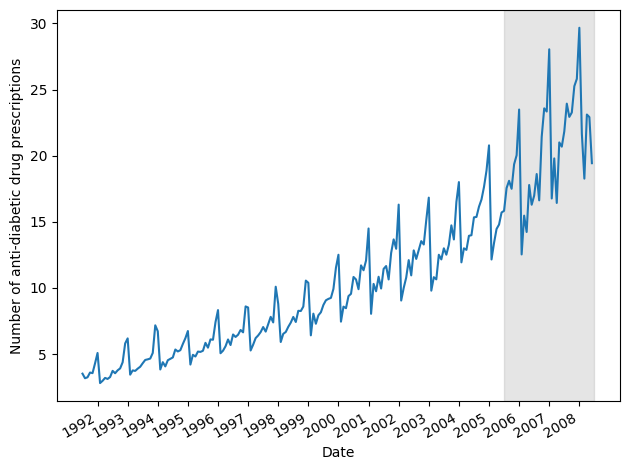

In [12]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.axvspan(168, 204, color='#808080', alpha=0.2)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH11_F_peixeiro.png', dpi=300)

### SARIMA(p,1,q)(P,1,Q)<sub>12<sub> 

In [13]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [14]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)
Ps = range(0, 5, 1)
Qs = range(0, 5, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 12

In [15]:
# SARIMA_result_df = optimize_SARIMAX(train, None, order_list, d, D, s)
# SARIMA_result_df[:20]

id	(p,q,P,Q)	AIC  
0	(3, 1, 1, 3)	270.951096  
1	(2, 4, 1, 3)	271.214101  
2	(3, 3, 1, 3)	271.456197   
3	(4, 1, 1, 3)	272.145292   
4	(0, 4, 1, 3)	272.152380   
5	(3, 2, 1, 3)	272.222636  
6	(2, 4, 0, 1)	272.545713   
7	(3, 3, 0, 1)	272.580414  
8	(3, 1, 1, 4)	272.909235   
9	(3, 3, 2, 0)	272.949439   
10	(2, 4, 2, 0)	272.949667  
11	(3, 4, 1, 3)	273.232120  
12	(1, 1, 1, 3)	273.281585   
13	(3, 1, 2, 3)	273.304223   
14	(0, 1, 1, 3)	273.367406  
15	(0, 3, 1, 3)	273.420763  
16	(0, 2, 1, 3)	273.701993  
17	(1, 4, 1, 3)	273.801356   
18	(4, 4, 1, 3)	273.832536  
19	(2, 4, 2, 3)	274.099369 


In [16]:
SARIMA_model = SARIMAX(train, order=(3,1,1), seasonal_order=(1,1,3,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  168
Model:             SARIMAX(3, 1, 1)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -126.476
Date:                                    Wed, 18 Feb 2026   AIC                            270.951
Time:                                            13:11:03   BIC                            298.342
Sample:                                                 0   HQIC                           282.077
                                                    - 168                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0680      0.091      0.747      0

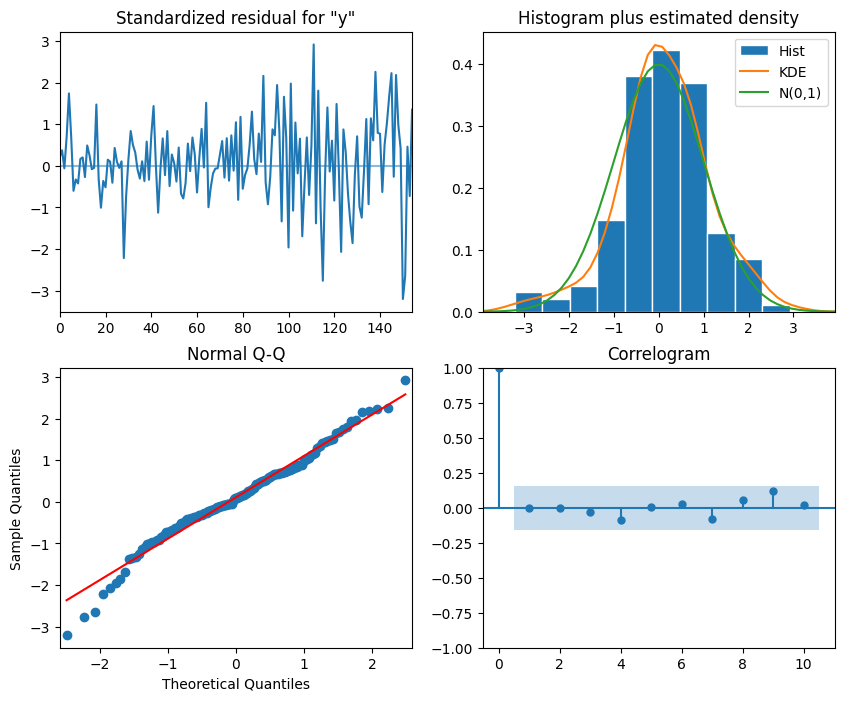

In [17]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

plt.savefig('figures/CH11_F04_peixeiro.png', dpi=300)

In [ ]:
# residuals = SARIMA_model_fit.resid

# lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# print(pvalue)

lb_pvalue


In [27]:
residuals = SARIMA_model_fit.resid
lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))
lb_dataframe

,lb_stat,lb_pvalue
1,0.436663,0.508737
2,0.626906,0.730919
3,0.645470,0.885949
4,2.257212,0.688570
5,2.949211,0.707816
6,3.388120,0.758790
7,9.980458,0.189684
8,10.590330,0.226009
9,11.851903,0.221788
10,11.983270,0.286178


## Forecasting 

In [19]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df['y'][:i], order=(2,1,3), seasonal_order=(1,1,3,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA

In [20]:
pred_df = df[168:]

pred_df

,ds,y
168,2005-07-01,15.829550
169,2005-08-01,17.554701
170,2005-09-01,18.100864
171,2005-10-01,17.496668
172,2005-11-01,19.347265
173,2005-12-01,20.031291
174,2006-01-01,23.486694
175,2006-02-01,12.536987
176,2006-03-01,15.467018
177,2006-04-01,14.233539


In [21]:
TRAIN_LEN = 168
HORIZON = 36
WINDOW = 12

pred_df['last_season'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')

pred_df

,ds,y,last_season
168,2005-07-01,15.829550,15.339097
169,2005-08-01,17.554701,15.370764
170,2005-09-01,18.100864,16.142005
171,2005-10-01,17.496668,16.685754
172,2005-11-01,19.347265,17.636728
173,2005-12-01,20.031291,18.869325
174,2006-01-01,23.486694,20.778723
175,2006-02-01,12.536987,12.154552
176,2006-03-01,15.467018,13.402392
177,2006-04-01,14.233539,14.459239


In [22]:
pred_df['SARIMA'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

pred_df

,ds,y,last_season,SARIMA
168,2005-07-01,15.829550,15.339097,16.751836
169,2005-08-01,17.554701,15.370764,16.687075
170,2005-09-01,18.100864,16.142005,17.188717
171,2005-10-01,17.496668,16.685754,18.089563
172,2005-11-01,19.347265,17.636728,18.661720
173,2005-12-01,20.031291,18.869325,19.944588
174,2006-01-01,23.486694,20.778723,22.079398
175,2006-02-01,12.536987,12.154552,13.744484
176,2006-03-01,15.467018,13.402392,15.082528
177,2006-04-01,14.233539,14.459239,15.656047


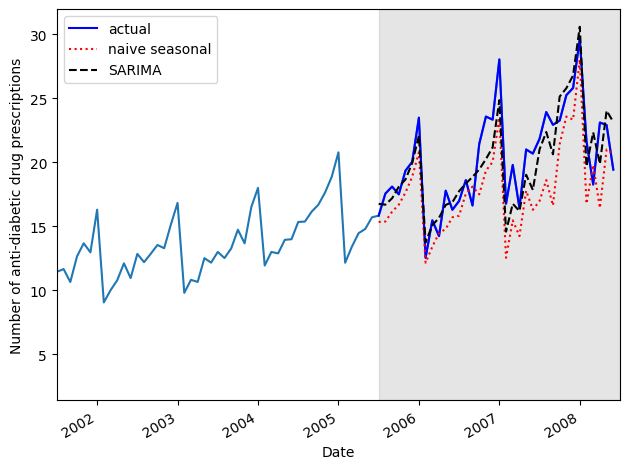

In [23]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.plot(pred_df.y, 'b-', label='actual')
ax.plot(pred_df.last_season, 'r:', label='naive seasonal')
ax.plot(pred_df.SARIMA, 'k--', label='SARIMA')
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.axvspan(168, 204, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
plt.xlim(120, 204)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH11_F05_peixeiro.png', dpi=300)

## Evaluate 

In [24]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [25]:
mape_naive_seasonal = mape(pred_df.y, pred_df.last_season)
mape_SARIMA = mape(pred_df.y, pred_df.SARIMA)

print(mape_naive_seasonal, mape_SARIMA)

12.686561923100614 7.899486788566618


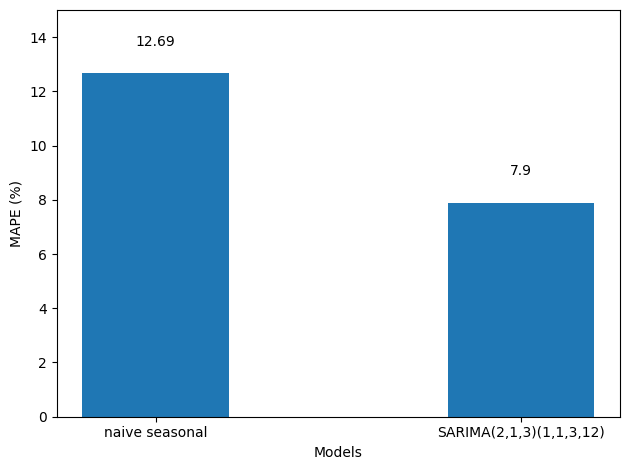

In [26]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'SARIMA(2,1,3)(1,1,3,12)']
y = [mape_naive_seasonal, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH11_F06_peixeiro.png', dpi=300)